In [ ]:
!pip install xgboost optuna numpy pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import os

uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]
os.rename(uploaded_filename, 'clean.csv')

Saving clean.csv to clean.csv


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna  # For hyperparameter tuning
from sklearn.model_selection import KFold
from scipy.linalg import cholesky
from scipy.stats import multivariate_normal

import numpy as np
import xgboost as xgb
from scipy.linalg import cholesky
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

In [ ]:
seed = 42
np.random.seed(seed)

data = pd.read_csv('clean.csv')

# Frequency encode categorical variables
categorical_columns = ['rating', 'risk_rating', 'category']
for col in categorical_columns:
    freq_encoding = data[col].value_counts().to_dict()
    data[col] = data[col].map(freq_encoding)

# Define predictor and target variables
X = data.drop(columns=['roe', 'sustainability_score'])
y = data[['roe', 'sustainability_score']]

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
rsr_scores = []

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold + 1}...")

    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute empirical covariance matrix of targets
    cov_matrix = np.cov(y_train.T)

    # Ensure positive definiteness and perform Cholesky decomposition
    L = cholesky(cov_matrix, lower=True)

    # Transform target variables
    y_train_transformed = np.linalg.solve(L, y_train.T).T

    # Train XGBoost models for each transformed response
    models = []
    for i in range(y_train_transformed.shape[1]):
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
        model.fit(X_train, y_train_transformed[:, i])
        models.append(model)

    # Predict transformed responses
    y_pred_transformed = np.column_stack([model.predict(X_val) for model in models])

    # Transform back to original space using Cholesky factor
    y_pred = (L @ y_pred_transformed.T).T

    # Compute Root Squared Residual (RSR)
    rsr = np.sqrt(np.mean((y_val - y_pred) ** 2, axis=0)) / np.std(y_val, axis=0)
    rsr_scores.append(rsr)
    print(f'Root Squared Residual (RSR) for Fold {fold + 1}: {rsr}')


Training fold 1...
Root Squared Residual (RSR) for Fold 1: roe                     0.313874
sustainability_score    0.469934
dtype: float64

Training fold 2...
Root Squared Residual (RSR) for Fold 2: roe                     0.360892
sustainability_score    0.651109
dtype: float64

Training fold 3...
Root Squared Residual (RSR) for Fold 3: roe                     0.279893
sustainability_score    0.468806
dtype: float64

Training fold 4...
Root Squared Residual (RSR) for Fold 4: roe                     0.325490
sustainability_score    0.613386
dtype: float64

Training fold 5...
Root Squared Residual (RSR) for Fold 5: roe                     0.267346
sustainability_score    0.507036
dtype: float64


In [ ]:
# Compute the average RSR across all folds
average_rsr = np.mean(rsr_scores, axis=0)

# Compute ARSR across all responses
arsr = np.mean(average_rsr)

print(f'Average RSR across all folds: {arsr}')

Average RSR across all folds: 0.4257766351244106


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
rsr_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold + 1}...")

    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute empirical covariance matrix of targets
    cov_matrix = np.cov(y_train.T)

    # Low-rank approximation using Truncated SVD
    rank = min(y_train.shape[1], 10)  # Adjust rank as needed
    svd = TruncatedSVD(n_components=rank)
    low_rank_cov = svd.fit_transform(cov_matrix) @ svd.components_

    # Ensure positive definiteness and perform Cholesky decomposition
    L = cholesky(low_rank_cov + np.eye(low_rank_cov.shape[0]) * 1e-6, lower=True)

    # Transform target variables
    y_train_transformed = np.linalg.solve(L, y_train.T).T

    # Train XGBoost models for each transformed response
    models = []
    for i in range(y_train_transformed.shape[1]):
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
        model.fit(X_train, y_train_transformed[:, i])
        models.append(model)

    # Predict transformed responses
    y_pred_transformed = np.column_stack([model.predict(X_val) for model in models])

    # Transform back to original space using low-rank Cholesky factor
    y_pred = (L @ y_pred_transformed.T).T

    # Compute Root Squared Residual (RSR)
    rsr = np.sqrt(np.mean((y_val - y_pred) ** 2, axis=0)) / np.std(y_val, axis=0)
    rsr_scores.append(rsr)
    print(f'Root Squared Residual (RSR) for Fold {fold + 1}: {rsr}')


Training fold 1...
Root Squared Residual (RSR) for Fold 1: roe                     0.313874
sustainability_score    0.471942
dtype: float64

Training fold 2...
Root Squared Residual (RSR) for Fold 2: roe                     0.360591
sustainability_score    0.651034
dtype: float64

Training fold 3...
Root Squared Residual (RSR) for Fold 3: roe                     0.279893
sustainability_score    0.468806
dtype: float64

Training fold 4...
Root Squared Residual (RSR) for Fold 4: roe                     0.326104
sustainability_score    0.613488
dtype: float64

Training fold 5...
Root Squared Residual (RSR) for Fold 5: roe                     0.267346
sustainability_score    0.507036
dtype: float64


In [ ]:
# Compute the average RSR across all folds
average_rsr = np.mean(rsr_scores, axis=0)

# Compute ARSR across all responses
arsr = np.mean(average_rsr)

print(f'Average RSR across all folds: {arsr}')

Average RSR across all folds: 0.42601135534946644



Training fold 1...
Root Squared Residual (RSR) for Fold 1: roe                     0.313874
sustainability_score    0.471942
dtype: float64

Training fold 2...
Root Squared Residual (RSR) for Fold 2: roe                     0.360591
sustainability_score    0.651034
dtype: float64

Training fold 3...
Root Squared Residual (RSR) for Fold 3: roe                     0.279893
sustainability_score    0.468806
dtype: float64

Training fold 4...
Root Squared Residual (RSR) for Fold 4: roe                     0.326104
sustainability_score    0.613488
dtype: float64

Training fold 5...
Root Squared Residual (RSR) for Fold 5: roe                     0.267346
sustainability_score    0.507036
dtype: float64


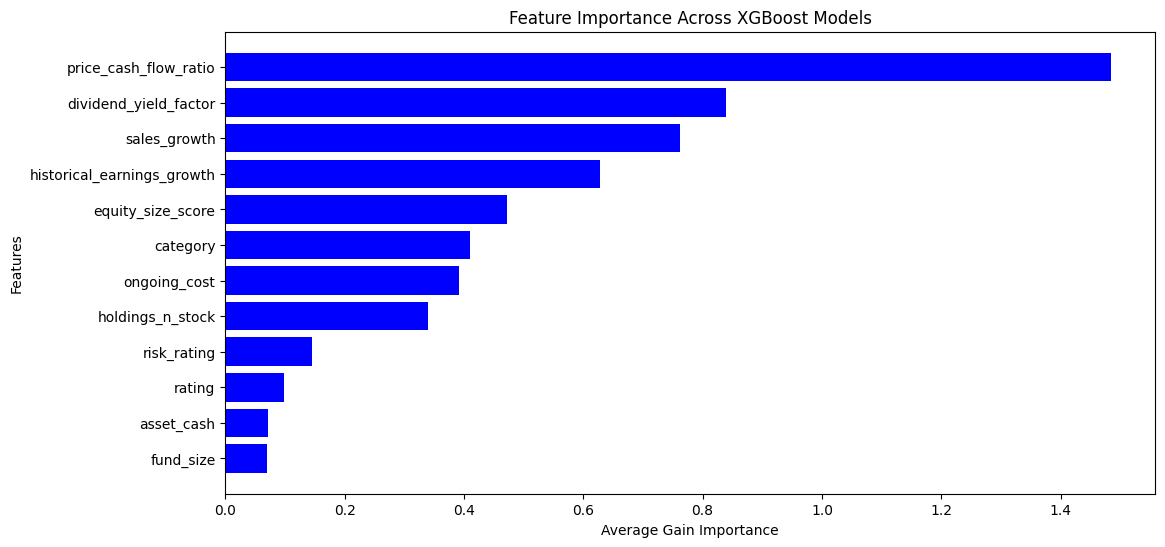

In [ ]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
rsr_scores = []
feature_importance = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold + 1}...")

    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute empirical covariance matrix of targets
    cov_matrix = np.cov(y_train.T)

    # Low-rank approximation using Truncated SVD
    rank = min(y_train.shape[1], 10)  # Adjust rank based on dataset size
    svd = TruncatedSVD(n_components=rank)
    low_rank_cov = svd.fit_transform(cov_matrix) @ svd.components_

    # Ensure positive definiteness (regularization)
    epsilon = 1e-6
    L = cholesky(low_rank_cov + np.eye(low_rank_cov.shape[0]) * epsilon, lower=True)

    # Transform target variables
    y_train_transformed = np.linalg.solve(L, y_train.T).T

    # Train XGBoost models for each transformed response
    models = []
    for i in range(y_train_transformed.shape[1]):
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)
        model.fit(X_train, y_train_transformed[:, i])

        # Aggregate feature importance scores
        importance = model.get_booster().get_score(importance_type="gain")
        for feature, score in importance.items():
            if feature in feature_importance:
                feature_importance[feature].append(score)
            else:
                feature_importance[feature] = [score]

        models.append(model)

    # Predict transformed responses
    y_pred_transformed = np.column_stack([model.predict(X_val) for model in models])

    # Transform back to original space
    y_pred = (L @ y_pred_transformed.T).T

    # Compute Root Squared Residual (RSR)
    rsr = np.sqrt(np.mean((y_val - y_pred) ** 2, axis=0)) / np.std(y_val, axis=0)
    rsr_scores.append(rsr)
    print(f'Root Squared Residual (RSR) for Fold {fold + 1}: {rsr}')

# --- Feature Importance Plot ---
# Compute average importance
avg_feature_importance = {feat: np.mean(scores) for feat, scores in feature_importance.items()}
sorted_importance = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance], color='blue')
plt.xlabel("Average Gain Importance")
plt.ylabel("Features")
plt.title("Feature Importance Across XGBoost Models")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

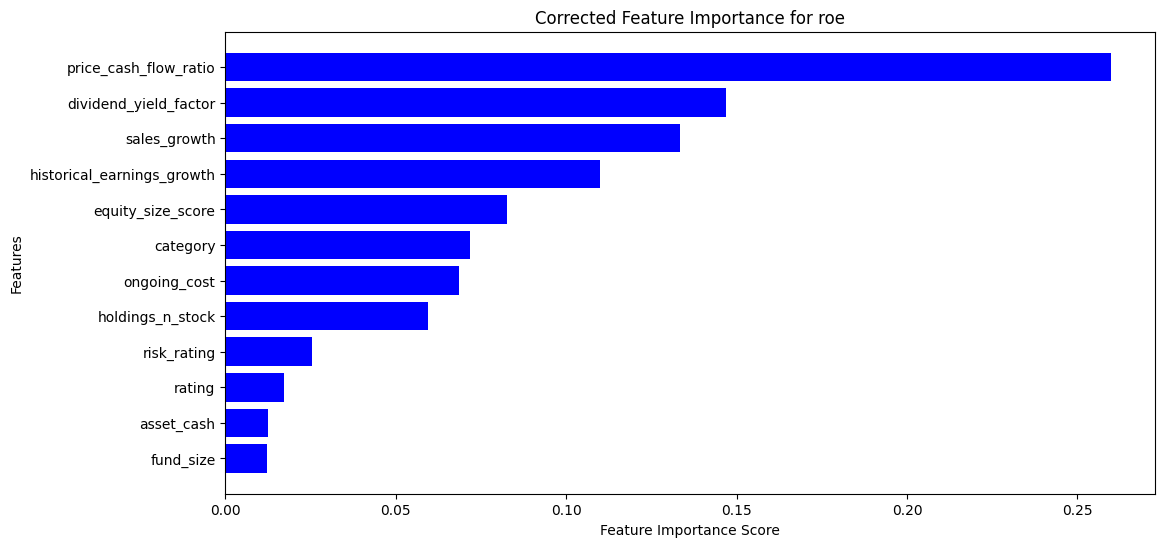

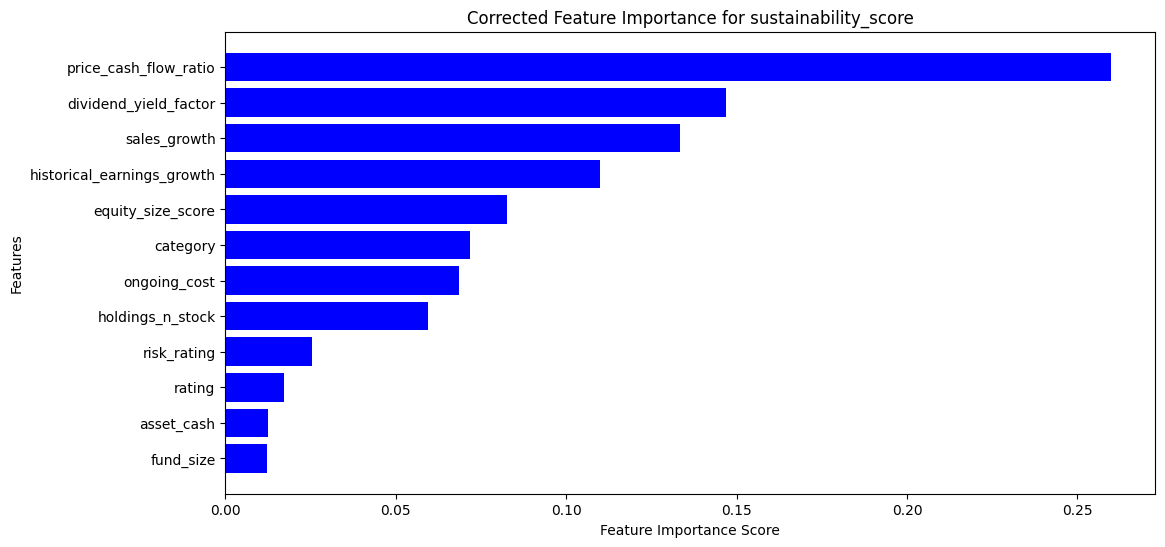

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert feature importance dictionary to an array
feature_names = list(feature_importance.keys())
importance_values = np.array([np.mean(scores) for scores in feature_importance.values()])

# Convert to matrix for transformation back to original response space
importance_matrix = np.zeros((len(feature_names), rank))  # rank = transformed response count
for i, feature in enumerate(feature_names):
    importance_matrix[i, :] = importance_values[i]

# --- Correct Feature Importance Mapping ---
# Use L.T to move feature importance from transformed space back to original responses
response_importance = L.T @ importance_matrix.T  # (original responses x features)

# Normalize per response
response_importance /= np.sum(response_importance, axis=1, keepdims=True)

# --- Plot Corrected Feature Importance for Each Response ---
responses = ["roe", "sustainability_score"]
for i, response in enumerate(responses):
    plt.figure(figsize=(12, 6))
    sorted_indices = np.argsort(response_importance[i, :])[::-1]
    sorted_features = [feature_names[idx] for idx in sorted_indices]
    sorted_values = response_importance[i, sorted_indices]

    plt.barh(sorted_features, sorted_values, color='blue')
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title(f"Corrected Feature Importance for {response}")
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
rsr_scores = []
feature_importance = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold + 1}...")

    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute empirical covariance matrix of targets
    cov_matrix = np.cov(y_train.T)

    # Low-rank approximation using Truncated SVD
    rank = min(y_train.shape[1], 10)  # Adjust rank based on dataset size
    svd = TruncatedSVD(n_components=rank)
    low_rank_cov = svd.fit_transform(cov_matrix) @ svd.components_

    # Ensure positive definiteness (regularization)
    epsilon = 1e-6
    L = cholesky(low_rank_cov + np.eye(low_rank_cov.shape[0]) * epsilon, lower=True)

    # Print L to check if it's close to identity
    print("Cholesky factor L:\n", L)

    # Transform target variables
    y_train_transformed = np.linalg.solve(L, y_train.T).T

    # Train a single multi-output XGBoost model
    model = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", random_state=seed))
    model.fit(X_train, y_train_transformed)

    # Predict transformed responses
    y_pred_transformed = model.predict(X_val)

    # Transform back to original space
    y_pred = (L @ y_pred_transformed.T).T

    # Compute Root Squared Residual (RSR)
    rsr = np.sqrt(np.mean((y_val - y_pred) ** 2, axis=0)) / np.std(y_val, axis=0)
    rsr_scores.append(rsr)
    print(f'Root Squared Residual (RSR) for Fold {fold + 1}: {rsr}')

    # Convert importance dictionaries to matrix form
    importance_matrix = np.zeros((len(X_train.columns), len(model.estimators_)))

    for i, estimator in enumerate(model.estimators_):
        importance = estimator.get_booster().get_score(importance_type="gain")

        for j, feature in enumerate(X_train.columns):
            importance_matrix[j, i] = importance.get(feature, 0)  # Ensure correct indexing

    # Compute inverse of L
    L_inv = np.linalg.inv(L)

    # Transform feature importance back to original response space
    response_importance = L_inv @ importance_matrix.T  # Back-project importance

    # Convert back to dictionary for plotting
    feature_importance = {}
    for i, response in enumerate(["roe", "sustainability_score"]):
        feature_importance[response] = response_importance[i, :]



Training fold 1...
Cholesky factor L:
 [[ 7.77503704  0.        ]
 [-1.04667264  3.32368668]]
Root Squared Residual (RSR) for Fold 1: roe                     0.313874
sustainability_score    0.471942
dtype: float64

Training fold 2...
Cholesky factor L:
 [[ 7.78769677  0.        ]
 [-1.13762025  3.4954419 ]]
Root Squared Residual (RSR) for Fold 2: roe                     0.360591
sustainability_score    0.651034
dtype: float64

Training fold 3...
Cholesky factor L:
 [[ 8.09569671  0.        ]
 [-1.15349321  3.42551661]]
Root Squared Residual (RSR) for Fold 3: roe                     0.279893
sustainability_score    0.468806
dtype: float64

Training fold 4...
Cholesky factor L:
 [[ 7.94322522  0.        ]
 [-1.15528772  3.31448699]]
Root Squared Residual (RSR) for Fold 4: roe                     0.326104
sustainability_score    0.613488
dtype: float64

Training fold 5...
Cholesky factor L:
 [[ 7.76599808  0.        ]
 [-1.09194941  3.39166431]]
Root Squared Residual (RSR) for Fold 5: r

In [ ]:
# Compute the average RSR across all folds
average_rsr = np.mean(rsr_scores, axis=0)

# Compute ARSR across all responses
arsr = np.mean(average_rsr)

print(f'Average RSR across all folds: {arsr}')

Average RSR across all folds: 0.42601135534946644


In [ ]:
print("First few predictions (Transformed Space):\n", model.predict(X_train)[:5])

First few predictions (Transformed Space):
 [[2.925038  7.55788  ]
 [1.9148175 6.199177 ]
 [1.2955189 6.5193014]
 [1.1239252 7.427985 ]
 [4.0018983 8.025265 ]]


In [ ]:
# Print matrices before normalization
print("Feature Importance Matrix (Transformed Space):\n", importance_matrix)
print("Back-Projected Response Importance:\n", response_importance)

# Check if any values are NaN or zero
print("Any NaN in response importance?", np.isnan(response_importance).any())
print("Any zero rows in response importance?", np.all(response_importance == 0, axis=1))


Feature Importance Matrix (Transformed Space):
 [[0.28247941 0.56206769]
 [0.04756061 0.16656101]
 [0.12727103 0.19323175]
 [0.82194179 0.24395983]
 [2.05395007 0.80611861]
 [0.64867216 0.4546608 ]
 [0.38803488 0.55787039]
 [0.19561291 1.44546616]
 [0.04565402 0.06298506]
 [0.08124896 0.82590604]
 [0.2201443  0.374594  ]
 [0.04328777 0.04753162]]
Back-Projected Response Importance:
 [[0.03637387 0.00612421 0.01638824 0.10583853 0.26447986 0.08352721
  0.04996587 0.02518838 0.00587871 0.01046214 0.0283472  0.00557401]
 [0.17743092 0.05108063 0.06224875 0.10600405 0.32282594 0.16094408
  0.18056934 0.43429139 0.0204632  0.24687884 0.11957189 0.0158088 ]]
Any NaN in response importance? False
Any zero rows in response importance? [False False]


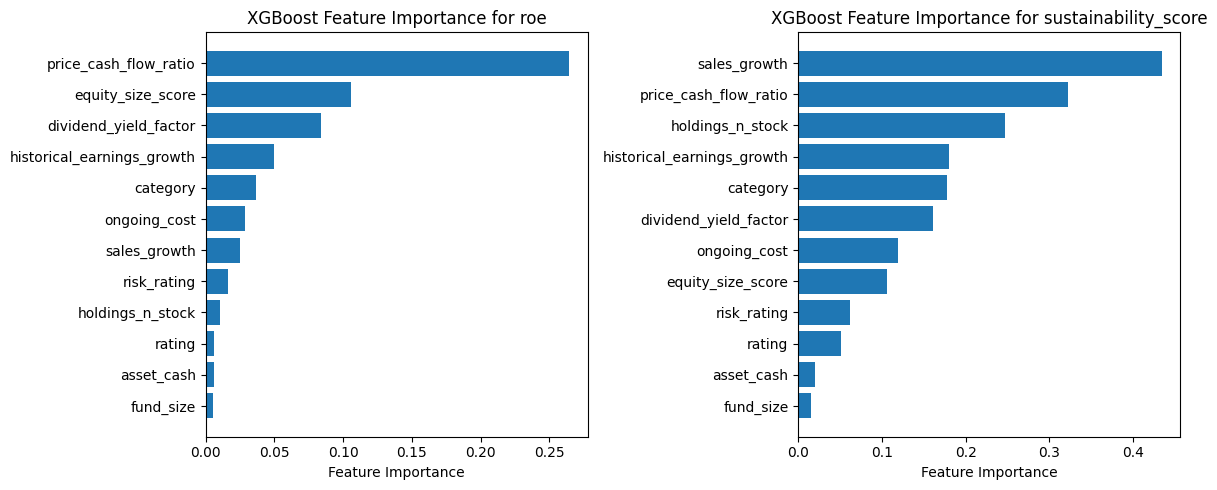

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame
importance_df = pd.DataFrame(feature_importance, index=X_train.columns)

# Reset index for plotting
importance_df.reset_index(inplace=True)
importance_df.rename(columns={'index': 'Feature'}, inplace=True)

# Create subplots for feature importance per response
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two plots side by side

for i, response in enumerate(["roe", "sustainability_score"]):
    # Sort the DataFrame by feature importance in descending order
    sorted_df = importance_df.sort_values(by=response, ascending=False)

    # Plot
    axes[i].barh(sorted_df["Feature"], sorted_df[response], align="center")
    axes[i].set_title(f"XGBoost Feature Importance for {response}")
    axes[i].set_xlabel("Feature Importance")
    axes[i].invert_yaxis()  # Highest importance at the top

plt.tight_layout()
plt.show()
